Setting up image transformations for training and testing...
Image transformations are ready.
Defining custom dataset class for wheat disease images...
Custom dataset class defined.
Preparing data loaders and splitting dataset if needed...
Loading data...
Found existing split dataset. Loading splits...
Calculating class weights for balanced sampling...
Data loaders are ready.
Data loaded. Classes: ['aphid', 'army_worm', 'black_rust', 'brown_rust', 'common_rust', 'fusarium_head_blight', 'healthy', 'leaf_blight', 'powdery_mildew_leaf', 'spetoria', 'tan_spot', 'yellow_rust']
Initializing model...
Using device: cuda
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050
Model initialized. Starting training...
Model device: cuda:0
Epoch 1/20


C:\Users\sayfp\AppData\Local\Temp\ipykernel_11452\3760563208.py:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):


Train Loss: 350.8523 Acc: 0.0904


C:\Users\sayfp\AppData\Local\Temp\ipykernel_11452\3760563208.py:257: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):


Val Loss: 106.3094 Acc: 0.1133 | LR: 0.000100 | Time: 50.7s
Epoch 2/20
Train Loss: 39.0166 Acc: 0.1052
Train Loss: 39.0166 Acc: 0.1052
Val Loss: 5.2477 Acc: 0.1667 | LR: 0.000100 | Time: 52.2s
Epoch 3/20
Val Loss: 5.2477 Acc: 0.1667 | LR: 0.000100 | Time: 52.2s
Epoch 3/20
Train Loss: 3.6626 Acc: 0.1685
Train Loss: 3.6626 Acc: 0.1685
Val Loss: 4.5196 Acc: 0.2311 | LR: 0.000100 | Time: 50.4s
Epoch 4/20
Val Loss: 4.5196 Acc: 0.2311 | LR: 0.000100 | Time: 50.4s
Epoch 4/20
Train Loss: 3.1767 Acc: 0.1937
Train Loss: 3.1767 Acc: 0.1937
Val Loss: 3.4035 Acc: 0.2422 | LR: 0.000100 | Time: 50.9s
Epoch 5/20
Val Loss: 3.4035 Acc: 0.2422 | LR: 0.000100 | Time: 50.9s
Epoch 5/20
Train Loss: 3.0384 Acc: 0.2594
Train Loss: 3.0384 Acc: 0.2594
Val Loss: 3.0223 Acc: 0.2956 | LR: 0.000100 | Time: 49.7s
Epoch 6/20
Val Loss: 3.0223 Acc: 0.2956 | LR: 0.000100 | Time: 49.7s
Epoch 6/20
Train Loss: 2.5113 Acc: 0.3122
Train Loss: 2.5113 Acc: 0.3122
Val Loss: 2.6539 Acc: 0.3400 | LR: 0.000100 | Time: 48.4s
Epoch 7

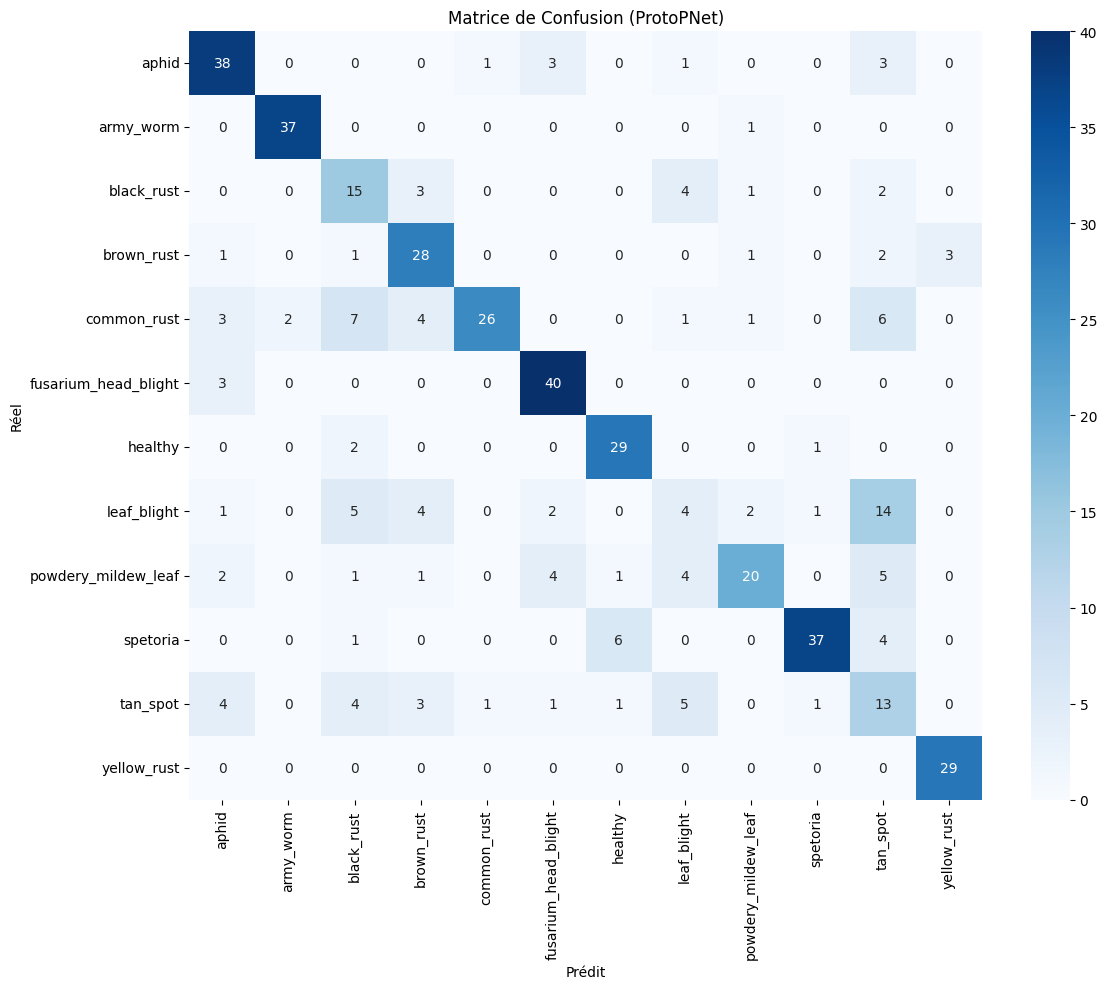


Rapport de classification:
                      precision    recall  f1-score   support

               aphid     0.7308    0.8261    0.7755        46
           army_worm     0.9487    0.9737    0.9610        38
          black_rust     0.4167    0.6000    0.4918        25
          brown_rust     0.6512    0.7778    0.7089        36
         common_rust     0.9286    0.5200    0.6667        50
fusarium_head_blight     0.8000    0.9302    0.8602        43
             healthy     0.7838    0.9062    0.8406        32
         leaf_blight     0.2105    0.1212    0.1538        33
 powdery_mildew_leaf     0.7692    0.5263    0.6250        38
            spetoria     0.9250    0.7708    0.8409        48
            tan_spot     0.2653    0.3939    0.3171        33
         yellow_rust     0.9062    1.0000    0.9508        29

            accuracy                         0.7007       451
           macro avg     0.6947    0.6955    0.6827       451
        weighted avg     0.7207    0.700

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import numpy as np
import shutil
import time

# -----------------------------
# Configuration
# -----------------------------
DATASET_DIR = 'dataset'
SAVE_DIR = 'saved_models_and_data'
SPLIT_OUTPUT_DIR = 'dataset_split' # New: Directory to save split images
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32  # Increased batch size for better GPU utilization
TEST_SIZE = 0.15 # New: For dataset splitting
VAL_SIZE = 0.15 # New: For dataset splitting
EPOCHS = 20
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5 # New: For early stopping
PROTOTYPE_SHAPE = (128, 512, 1, 1)  # 128 prototypes, 512 channels, 1x1 spatial
USE_MIXED_PRECISION = True if torch.cuda.is_available() else False # New: For mixed precision training

os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(SPLIT_OUTPUT_DIR, exist_ok=True) # Ensure split directory exists

# -----------------------------
# Seed Setting
# -----------------------------
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# -----------------------------
# Transformations
# -----------------------------
print('Setting up image transformations for training and testing...')
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), # Added from convnext
    transforms.RandomRotation(45),    # Added from convnext
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Added from convnext
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
print('Image transformations are ready.')


# -----------------------------
# Custom Dataset
# -----------------------------
print('Defining custom dataset class for wheat disease images...')
class WheatDiseaseDataset(Dataset): # Changed from torch.utils.data.Dataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(root_dir, target_class)
            # Ensure it's a directory before listing
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    path = os.path.join(class_dir, img_file)
                    self.samples.append((path, self.class_to_idx[target_class]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            image = Image.open(path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, target
        except Exception as e:
            print(f"Erreur lors du chargement de {path}: {e}")
            # Fallback: try to load the next image in the dataset to avoid stopping
            # This might create bias if many images are corrupted consecutively
            return self.__getitem__((idx + 1) % len(self))
print('Custom dataset class defined.')

# -----------------------------
# Load and Split Dataset (Refactored)
# -----------------------------
print('Preparing data loaders and splitting dataset if needed...')
def get_data_loaders():
    split_dirs = [os.path.join(SPLIT_OUTPUT_DIR, split) for split in ['train', 'val', 'test']]
    # Check if split directories exist and are not empty
    split_exists = all(os.path.isdir(d) and len(os.listdir(d)) > 0 for d in split_dirs)

    if split_exists:
        print('Found existing split dataset. Loading splits...')
        train_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'train'), transform=train_transform)
        val_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'val'), transform=test_transform)
        test_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'test'), transform=test_transform)
    else:
        print('No split dataset found. Splitting and saving images...')
        full_dataset = WheatDiseaseDataset(DATASET_DIR, transform=None) # Use None transform for initial loading

        generator = torch.Generator().manual_seed(42)
        indices = torch.randperm(len(full_dataset), generator=generator).tolist()

        train_size = int((1 - TEST_SIZE - VAL_SIZE) * len(full_dataset))
        val_size = int(VAL_SIZE * len(full_dataset))
        # test_size is implicitly the rest
        # test_size = len(full_dataset) - train_size - val_size

        train_indices = indices[:train_size]
        val_indices = indices[train_size:train_size + val_size]
        test_indices = indices[train_size + val_size:]

        # Create Subset objects for initial splitting (before saving to disk)
        train_data_subset = Subset(full_dataset, train_indices)
        val_data_subset = Subset(full_dataset, val_indices)
        test_data_subset = Subset(full_dataset, test_indices)

        def save_split_images(dataset_subset, split_name):
            print(f"Saving images for split: {split_name}")
            for idx_in_subset in range(len(dataset_subset)):
                original_idx = dataset_subset.indices[idx_in_subset] # Get original index from subset
                path, label_idx = full_dataset.samples[original_idx] # Use full_dataset to get original path
                class_name = full_dataset.classes[label_idx]
                filename = os.path.basename(path)
                dest_dir = os.path.join(SPLIT_OUTPUT_DIR, split_name, class_name)
                os.makedirs(dest_dir, exist_ok=True)
                dest_path = os.path.join(dest_dir, filename)
                shutil.copyfile(path, dest_path)

        save_split_images(train_data_subset, 'train')
        save_split_images(val_data_subset, 'val')
        save_split_images(test_data_subset, 'test')
        print('Image splits saved.')

        # Now, load datasets with appropriate transforms from the new split directories
        train_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'train'), transform=train_transform)
        val_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'val'), transform=test_transform)
        test_dataset = WheatDiseaseDataset(os.path.join(SPLIT_OUTPUT_DIR, 'test'), transform=test_transform)

    print('Calculating class weights for balanced sampling...')
    # Calculate class weights for the training set only
    targets = [s[1] for s in train_dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    print('Data loaders are ready.')
    return train_loader, val_loader, test_loader, train_dataset.classes

# ProtoPNet Model (No changes to the model architecture)
# -----------------------------
class ProtoPNet(nn.Module):
    def __init__(self, base_model, prototype_shape, num_classes):
        super().__init__()
        self.base_model = base_model
        self.prototype_shape = prototype_shape
        self.num_prototypes = prototype_shape[0]
        # Using nn.Parameter for learnable prototypes
        self.prototype_vectors = nn.Parameter(torch.randn(prototype_shape), requires_grad=True)
        # Last layer for classification
        self.last_layer = nn.Linear(self.num_prototypes, num_classes)

    def forward(self, x):
        # Feature extraction
        features = self.base_model(x)
        # Calculate distances to prototypes
        distances = self._l2_convolution(features)
        # Global min-pooling over H, W
        min_distances = torch.amin(distances, dim=(2, 3))  # [B, num_prototypes]
        # Convert distances to similarity scores
        prototype_activations = self.distance_2_similarity(min_distances)
        # Final classification layer
        logits = self.last_layer(prototype_activations)
        return logits, distances, features

    def _l2_convolution(self, x):
        # Calculate squared L2 norm of feature map activations
        x2 = torch.sum(x ** 2, dim=1, keepdim=True)
        # Calculate squared L2 norm of prototype vectors
        p2 = torch.sum(self.prototype_vectors ** 2, dim=(1, 2, 3))
        p2 = p2.view(1, -1, 1, 1) # Reshape for broadcasting
        # Reshape prototypes for convolution
        prototypes = self.prototype_vectors.squeeze(-1).squeeze(-1)
        # Calculate 2 * x * p component using convolution
        xp = nn.functional.conv2d(x, weight=prototypes.unsqueeze(-1).unsqueeze(-1))
        # Combine terms to get squared L2 distances
        distances = x2 - 2 * xp + p2
        return distances

    def distance_2_similarity(self, distances):
        # Convert distances to similarity (e.g., negative distance)
        return -distances

# -----------------------------
# Training Function (Refactored)
# -----------------------------
def train_model(model, device, train_loader, val_loader, num_epochs=EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    best_acc = 0.0
    no_improvement_epochs = 0
    scaler = torch.amp.GradScaler('cuda', enabled=USE_MIXED_PRECISION)
    print(f"Model device: {next(model.parameters()).device}")
    train_log = []
    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                logits, _, _ = model(inputs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            _, preds = torch.max(logits, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
                    logits, _, _ = model(inputs)
                    loss = criterion(logits, labels)

                _, preds = torch.max(logits, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | LR: {current_lr:.6f} | Time: {time.time()-start_time:.1f}s")

        scheduler.step(val_loss) # Update learning rate based on validation loss

        train_log.append({'epoch': epoch+1, 'train_loss': epoch_loss, 'train_acc': epoch_acc.item(),
                           'val_loss': val_loss, 'val_acc': val_acc.item(), 'lr': current_lr})

        # Save best model and early stopping
        if val_acc > best_acc:
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_protopnet_model.pth"))
            best_acc = val_acc
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {no_improvement_epochs} epochs without improvement.")
            break

    print("Entraînement ProtoPNet terminé.")
    print(f"Meilleure précision de validation: {best_acc:.4f}")
    return model, train_log

# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    print('Loading data...')
    train_loader, val_loader, test_loader, class_labels = get_data_loaders()
    NUM_CLASSES = len(class_labels)
    print('Data loaded. Classes:', class_labels)

    print('Initializing model...')
    base_model = models.resnet18(weights='IMAGENET1K_V1')
    base_model = nn.Sequential(*list(base_model.children())[:-2])  # Remove avgpool & fc

    model = ProtoPNet(base_model, PROTOTYPE_SHAPE, NUM_CLASSES)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"CUDA device count: {torch.cuda.device_count()}")
        print(f"Current CUDA device: {torch.cuda.current_device()}")
        print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

    print('Model initialized. Starting training...')
    model, train_log = train_model(model, device, train_loader, val_loader)
    print('Training complete. Evaluating on test set...')

    # Evaluation on Test Set (using the best saved model)
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_protopnet_model.pth"), map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            logits, _, _ = model(inputs)
            _, preds = torch.max(logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    from sklearn.metrics import classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    print('Test set predictions complete. Generating confusion matrix...')
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de Confusion (ProtoPNet)")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "protopnet_confusion_matrix.png")) # Save confusion matrix
    plt.show()

    print("\nRapport de classification:")
    print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    torch.save(model.state_dict(), os.path.join(SAVE_DIR, "wheat_disease_protopnet_final_model.pth"))
    print('Model saved to', os.path.join(SAVE_DIR, "wheat_disease_protopnet_final_model.pth"))


In [ ]:
# Prototype Visualization (Optional - uncomment to run)


print("\nStarting prototype visualization...")
save_prototype_visualizations(model, val_loader.dataset, save_dir=os.path.join(SAVE_DIR, "protopnet_prototypes"), num_prototypes=model.num_prototypes)
print("Prototype visualization complete.")